In [1]:

import os
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np


In [2]:

def generate_chunked_dataset(path, num_rows=100000, chunk_size=50000, seed=42):
    np.random.seed(seed)
    categories = ['electronics','clothing','home','sports','beauty','toys']
    countries = ['IN','US','GB','DE','FR','AU','CA']
    devices = ['mobile','desktop','tablet']

    if os.path.exists(path):
        os.remove(path)
    os.makedirs(os.path.dirname(path), exist_ok=True)

    rows_written = 0
    order_id = 1
    start_time = datetime(2023,1,1)

    while rows_written < num_rows:
        n = min(chunk_size, num_rows - rows_written)
        records = []
        for i in range(n):
            ts = start_time + timedelta(seconds=int(np.random.randint(0,60*60*24*365)))
            user_id = int(np.random.randint(1, num_rows//10 + 50))
            product_id = int(np.random.randint(1,5000))
            price = round(float(np.random.exponential(40)) + 1.0, 2)
            quantity = int(np.random.choice([1,1,1,2,3,4]))
            category = np.random.choice(categories)
            country = np.random.choice(countries, p=[0.5,0.15,0.08,0.07,0.06,0.08,0.06])
            device = np.random.choice(devices, p=[0.6,0.3,0.1])
            rating = float(np.clip(np.random.normal(4.0,0.9),1.0,5.0))
            records.append((order_id, ts.isoformat(), user_id, product_id, price, quantity, category, country, device, rating))
            order_id += 1
        df = pd.DataFrame(records, columns=['order_id','ts','user_id','product_id','price','quantity','category','country','device','rating'])
        header = (rows_written == 0)
        df.to_csv(path, mode='a', index=False, header=header)
        rows_written += n
        print(f'Wrote chunk, total rows = {rows_written}')
    print('Dataset generated at:', path)


In [3]:

def pyspark_analysis(csv_path, output_dir='output/pyspark', spark_master_local_cores=2, num_partitions=50):
    from pyspark.sql import SparkSession, functions as F, types as T

    os.makedirs(output_dir, exist_ok=True)

    spark = SparkSession.builder \
        .master(f'local[{spark_master_local_cores}]') \
        .appName('BigDataDemo') \
        .getOrCreate()

    schema = T.StructType([
        T.StructField('order_id', T.IntegerType()),
        T.StructField('ts', T.StringType()),
        T.StructField('user_id', T.IntegerType()),
        T.StructField('product_id', T.IntegerType()),
        T.StructField('price', T.DoubleType()),
        T.StructField('quantity', T.IntegerType()),
        T.StructField('category', T.StringType()),
        T.StructField('country', T.StringType()),
        T.StructField('device', T.StringType()),
        T.StructField('rating', T.DoubleType()),
    ])

    df = spark.read.csv(csv_path, header=True, schema=schema)

    df = df.withColumn('ts_ts', F.to_timestamp('ts')) \
           .withColumn('order_date', F.to_date('ts_ts')) \
           .withColumn('total_sales', F.col('price') * F.col('quantity'))

    df = df.filter(F.col('price') > 0)
    df = df.repartition(num_partitions, 'country')
    df.cache()

    top_products = df.groupBy('product_id') \
                     .agg(F.sum('total_sales').alias('sales')) \
                     .orderBy(F.desc('sales')) \
                     .limit(10)

    top_products.toPandas().to_csv(os.path.join(output_dir, 'top_products.csv'), index=False)

    spark.stop()


In [4]:

def scalability_demo():
    """Run scalability tests with different dataset sizes and partitions."""
    results = []
    dataset_sizes = [50000, 100000, 200000]
    partitions = [10, 50, 100]

    for rows in dataset_sizes:
        dataset_path = f"data/orders_{rows}.csv"
        generate_chunked_dataset(dataset_path, num_rows=rows, chunk_size=20000)
        for p in partitions:
            start = time.time()
            pyspark_analysis(dataset_path, output_dir=f"output/pyspark_{rows}_{p}", num_partitions=p)
            duration = time.time() - start
            results.append({"rows": rows, "partitions": p, "runtime_sec": round(duration,2)})
            print(f"Rows={rows}, Partitions={p}, Time={duration:.2f}s")

    df = pd.DataFrame(results)
    os.makedirs("output", exist_ok=True)
    df.to_csv("output/scalability_results.csv", index=False)
    print("\nScalability benchmark saved to output/scalability_results.csv")

    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4))
        for rows in df["rows"].unique():
            sub = df[df["rows"]==rows]
            plt.plot(sub["partitions"], sub["runtime_sec"], marker="o", label=f"{rows} rows")
        plt.xlabel("Number of Spark Partitions")
        plt.ylabel("Runtime (seconds)")
        plt.title("Scalability Demo")
        plt.legend()
        plt.savefig("output/scalability_plot.png")
        print("Scalability plot saved to output/scalability_plot.png")
    except Exception:
        pass


Wrote chunk, total rows = 20000
Wrote chunk, total rows = 40000
Wrote chunk, total rows = 50000
Dataset generated at: data/orders_50000.csv
Rows=50000, Partitions=10, Time=25.29s
Rows=50000, Partitions=50, Time=6.20s
Rows=50000, Partitions=100, Time=8.18s
Wrote chunk, total rows = 20000
Wrote chunk, total rows = 40000
Wrote chunk, total rows = 60000
Wrote chunk, total rows = 80000
Wrote chunk, total rows = 100000
Dataset generated at: data/orders_100000.csv
Rows=100000, Partitions=10, Time=4.13s
Rows=100000, Partitions=50, Time=6.65s
Rows=100000, Partitions=100, Time=6.15s
Wrote chunk, total rows = 20000
Wrote chunk, total rows = 40000
Wrote chunk, total rows = 60000
Wrote chunk, total rows = 80000
Wrote chunk, total rows = 100000
Wrote chunk, total rows = 120000
Wrote chunk, total rows = 140000
Wrote chunk, total rows = 160000
Wrote chunk, total rows = 180000
Wrote chunk, total rows = 200000
Dataset generated at: data/orders_200000.csv
Rows=200000, Partitions=10, Time=5.64s
Rows=20000

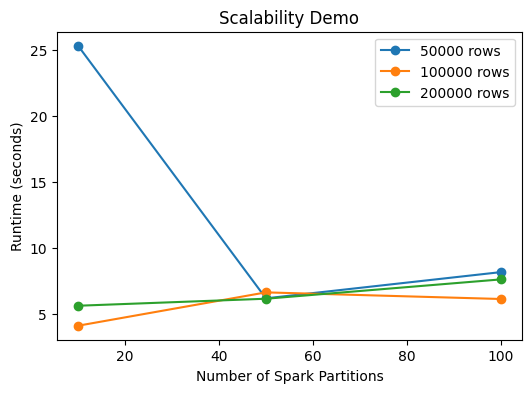

In [5]:

if __name__ == "__main__":
    scalability_demo()
